In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('CBIS-DDSM_combined.csv')
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,MALIGNANT,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,MALIGNANT,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,BENIGN,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,BENIGN,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,BENIGN,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [3]:
# Label Encoding for the 'pathology' column (MALIGNANT = 1, BENIGN = 0)
label_encoder = LabelEncoder()
df['pathology'] = label_encoder.fit_transform(df['pathology'])
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,1,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,1,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,0,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,0,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,0,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [4]:
# Prepare the image paths and labels
image_paths = df['image_path'].values
labels = df['pathology'].values

In [5]:
# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# ImageDataGenerator for rescaling only (no augmentation)
img_size = (256, 256)  # Resize images to a common size

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% of train data used for validation
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Flowing images from dataframe for training
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    subset='training'  # this is for training data
)

# Flowing images from dataframe for validation
validation_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    subset='validation'  # this is for validation data
)

# Flowing images from dataframe for testing
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 1833 validated image filenames.


Found 458 validated image filenames.
Found 573 validated image filenames.


In [7]:
# Building the custom CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model using the validation split from the training data
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.5197 - loss: 0.9056 - val_accuracy: 0.6070 - val_loss: 0.6678
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5960 - loss: 0.6711 - val_accuracy: 0.6266 - val_loss: 0.6374
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.6137 - loss: 0.6482 - val_accuracy: 0.6507 - val_loss: 0.6324
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.6592 - loss: 0.6009 - val_accuracy: 0.6528 - val_loss: 0.6124
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.7411 - loss: 0.5428 - val_accuracy: 0.6725 - val_loss: 0.5963
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.7474 - loss: 0.4919 - val_accuracy: 0.6790 - val_loss: 0.6000
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.8118 - loss: 0.4149 - val_accuracy: 0.6790 - val_loss: 0.6152
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.8516 - loss: 0.3411 - val_accuracy: 0.6921 - v

In [9]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.6888 - loss: 1.5280
Test Accuracy: 0.6702


In [21]:
model.save('model_dev.h5')

In [7]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('model_dev.h5')

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


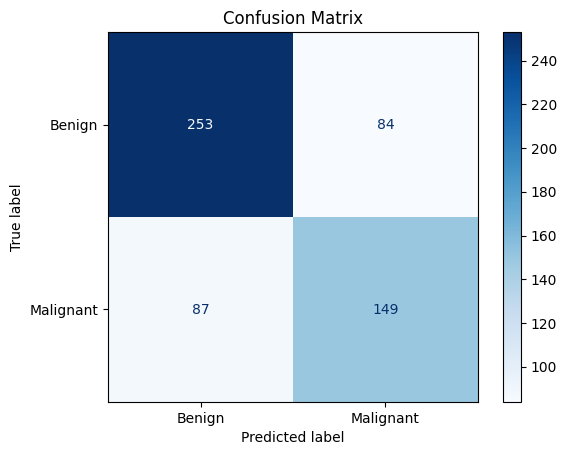

In [8]:
# Import additional necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels from the test generator
y_true = test_generator.labels
# Predict the labels (these will be probabilities)
y_pred_prob = model.predict(test_generator, steps=len(test_generator))

# Convert predicted probabilities to binary labels (threshold at 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

# Plot the confusion matrix using matplotlib
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()